# Learning hyperparameters for Total Variation Image denoising

The goal of this experiment is to optimize over hyperparameters of an unrolled iterative denoising optimization algorithm in order to maximize the proximity with ground truthed noiseless images, and to see how we can generalize to other similar images.

If we can do this, we have an automatic and adaptive way to tune these parameters on new data.

We want to find the best values for $\tau$ and the step size $\rho$ of the iterative algorithm, i.e. such that 

$\begin{equation*}
   \mathbf{x}(\tau,\rho) \approx \underset{\mathbf{x}}{\textrm{arg min}} \ \frac{1}{2} \left(||\mathbf{x}-\mathbf{y}||_{2}^2 + \tau ||\mathbf{Hx}||_{2,1}\right)
\end{equation*}$

    
and such that $||\mathbf{x}(\tau,\rho)-\mathbf{x}^{*}||^{2}$ is minimal over $\tau$ and $\rho$.


The data comes from a Panchromatic image (gray level image with a high spatial resolution), acquired over London, UK. We generate training data by splitting the image into patches, and noisy patches with various noise levels "by hand", artifically adding Gaussian white noise.

In [1]:
!pip install torch pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 14.5 MB/s 
     |████████████████████████████████| 529 kB 63.7 MB/s 
     |████████████████████████████████| 87 kB 7.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=93864ba015a26a2ab988e1bbd7b0655f0404a30e6d80007a74ea4b238d98286e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
# imports

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import imageio

from torch import autograd
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from torch import linalg as LA

from pytorch_lightning import loggers as pl_loggers

import pytorch_lightning as pl


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

torch.cuda.get_device_name(0)

cuda:0


'Tesla T4'

# Loading data and generating input/output pairs

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

!ls "/content/gdrive/MyDrive/AI_for_geophysical_dynamics/"

folder_name = "/content/gdrive/MyDrive/AI_for_geophysical_dynamics/"

Mounted at /content/gdrive
covtype.data  covtype.info  PAN_london.tif  PAN_tren.tif


In [4]:
# load image

I = torch.tensor(np.array(imageio.imread(folder_name + 'PAN_london.tif')[:,:],dtype=float))[None,None,:,:] # using pytorch format

# -> [batch_dim, channels, rows, columns]

# rescale it between 0 and 1

mini = torch.min(I.flatten())
maxi = torch.max(I.flatten())

I = (I-mini)/(maxi-mini)

# divide it into patches

patch_size = 128

def create_patches(I,patch_size):
    patches = torch.permute(F.unfold(I, patch_size, stride = patch_size//2),(2,0,1))
    return patches.view(patches.size()[0],1,patch_size,patch_size)

clean_imgs = create_patches(I,patch_size)

print(clean_imgs.size())

# display image

plt.figure(figsize = (30,30))
plt.imshow(I[0,0,:,:],cmap = 'gray')

Output hidden; open in https://colab.research.google.com to view.

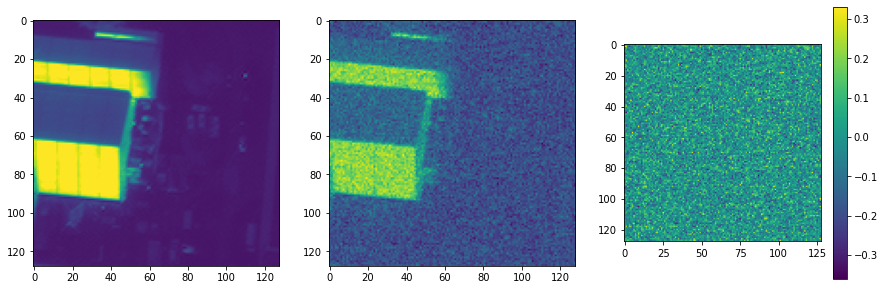

In [5]:
# create noisy imgs

SNR = 0 + (10)* torch.rand(clean_imgs.size()[0])# SNR uniformly sampled between 0 and 10 dB

noisy_imgs = torch.zeros(clean_imgs.size())

# loop over all patches

for i in range(clean_imgs.size()[0]):
        clean_imgs[i,0,:,:]
        var_noise = torch.var(clean_imgs[i,0,:,:].flatten())/(10**(SNR[i]/10)) # SNR = 10log(var(x)/var(noise))
        noisy_imgs[i,0,:,:] = clean_imgs[i,0,:,:] + torch.sqrt(var_noise)*torch.randn((patch_size,patch_size))

noise = noisy_imgs - clean_imgs

# display a given patch

idx = 200

plt.figure(figsize =(15,5))
plt.subplot(131)
plt.imshow(clean_imgs[idx,0,:,:])
plt.subplot(132)
plt.imshow(noisy_imgs[idx,0,:,:])
plt.subplot(133)
plt.imshow(noise[idx,0,:,:])
plt.colorbar()


In [6]:
print(clean_imgs.size())

train_lim = 400 # keep 400 images on which to learn parameters

x = clean_imgs[0:train_lim,:,:,:].to(device).double() # define x (to recover)
y = noisy_imgs[0:train_lim,:,:,:].to(device).double() # define y (corrupted)

torch.Size([961, 1, 128, 128])


# Implementing an algorithm to solve the denoising problem using Total Variation regularization

In this section, we perform (offline) optimization wrt the restored image using the hybrid proximal gradient descent (Condat-Vu algorithm). It is used to minimize a function of the type:

\begin{equation*}
 \underset{\mathbf{x}}{\textrm{arg min}} \ f(\mathbf{x}) + g(\mathbf{x}) + h(\mathbf{Hx})
\end{equation*}

where $f$ is differentiable, but $g$ and $h$ may not be. And $h$ involves a linear operator so that its argument does not have the same dimensions as those of $f$ and $g$.

The iterations write:

$\begin{align*}
& \mathbf{x}_{k+1} = \textbf{prox}_{\rho g} ( \mathbf{x}_{k}-\rho (\nabla f (\mathbf{x}_{k})+ \mathbf{H}^{\top}\mathbf{s}_{k} ))\\
& \mathbf{s}_{k+1} = \textbf{prox}_{\gamma h^{*}} (\mathbf{s}_{k} + \gamma \mathbf{H}(2\mathbf{x}_{k+1} - \mathbf{x}_{k})).
\end{align*}$

Here $\mathbf{H}\in \mathbb{R}^{2N \times N}$ (with $N$ the number of pixels in the image) is the matrix of the gradient operator. It is very large and we will never manipulate it explicitly, but instead only use computations of the products $\mathbf{Hx}$ and $\mathbf{H}^{T}\mathbf{x}$.

$\textbf{prox}_{\rho g}$ is projection on the interval $[0,1]$ and $\textbf{prox}_{\gamma h^{*}}$ is the projection on the $\mathcal{L}_{1}$ ball of radius $\tau$

Even though at this step we do not need automatic differentiation, the algorithm will be implemented using Pytorch (it will be useful later on). First we need a few auxiliary functions:

In [7]:
w1 = [-1,0,1] # first derivative
w0 = [0,1,0] # this is just to replicate along dimension for a 3*3 mask

v_grad_kernel = torch.tensor(np.outer(w1,w0)) # convolution kernel for the vertical gradient
v_grad_kernel = v_grad_kernel.view(1, 1, 3, 3).float().to(device)

h_grad_kernel = torch.tensor(np.outer(w1,w0).T)  # convolution kernel for the horizontal gradient
h_grad_kernel = h_grad_kernel.view(1, 1, 3, 3).float().to(device)


# This function computes the spatial gradient of a batch of images (output = [batch,2,rows,columns])

def compute_spatial_gradient_offline(x):

    h_grad = F.conv2d(x.float(), h_grad_kernel, padding = 1)
    v_grad = F.conv2d(x.float(), v_grad_kernel, padding = 1)

    return torch.cat((h_grad,v_grad),dim = 1)

# This computes the adjoint H^T*y, for y a vector of size (2*rows*columns) (output = [batch,1,rows,columns])

# The adjoint of the gradient is the negative divergence (with the same finite difference discretization)

def compute_adjoint_spatial_gradient_offline(q):

    q0 = q[:,0,:,:]
    q1 = q[:,1,:,:]

    h_grad = F.conv2d(q0[:,None,:,:].to(device).float(), h_grad_kernel, padding = 1)
    v_grad = F.conv2d(q1[:,None,:,:].to(device).float(), v_grad_kernel, padding = 1)

    return -(v_grad + h_grad)

# this function can compute the operator norm of an operator H, using only products Hx

def power_iteration(num_simulations):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = torch.rand((1,1,patch_size,patch_size)).to(device)

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
#         print(b_k.size())
        b_k1 = compute_adjoint_spatial_gradient_offline(compute_spatial_gradient_offline(b_k))

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1.flatten())

        # re normalize the vector
        b_k = (b_k1 / b_k1_norm)

    opnorm = torch.dot(b_k.flatten(),self.compute_adjoint_spatial_gradient(self.compute_spatial_gradient(b_k))[0,0,:].flatten())/ \
    torch.dot(b_k.flatten(),b_k.flatten())
    return opnorm

opnorm = torch.tensor(2.8205).to(device) # operator norm of gradient operator, computed with the power method


**Q: Compute the objective function, to be monitored along iterations**

In [8]:
# projection on the L2 ball of radius tau

def proj_l2_offline(x,tau):
    return x/torch.maximum(LA.norm(x, dim =1).unsqueeze(1).repeat(1, 2, 1, 1)/tau,torch.tensor(1).to(device))

# projection on the unit interval (optional)

def proj_unit_interval_offline(x):
    return torch.maximum(torch.minimum(x,torch.tensor(1)),torch.tensor(0).to(device))

# Algorithm, taking as input the corrupted image, the value of the regularization and step sizes, 
# and a maximum number of iterations

def condat_vu_offline(x, regul,step, maxiter):
    
    P = torch.clone(x).to(device)
    Q = torch.ones((x.size()[0],2,patch_size,patch_size)).to(device)

    tau = regul*torch.ones(x.size()[0]).to(device)    
    rho = step*torch.ones(tau.size()).to(device)  

     # to ensure convergence
    
    gamma_max = (1/rho - 1/2)/opnorm
    gamma = gamma_max  - 0.1
    
    loss = torch.zeros(maxiter).to(device)
    
    for i in range(maxiter):
        grad = P-x
        P_old = torch.clone(P).double().to(device)
        P = proj_unit_interval_offline(P-rho.to(device)*(grad + compute_adjoint_spatial_gradient_offline(Q)))
        Q = proj_l2_offline(Q+gamma.to(device)*compute_spatial_gradient_offline(2*P-P_old), tau.to(device))
        
        loss[i] = 1/2*torch.norm((P-x).flatten())**2 + \
            tau * torch.sum(LA.norm(compute_spatial_gradient_offline(P),dim = 1).flatten())

    return P,loss



We test that algorithm on a given noisy image:

tensor(4.4938)


Text(0.5, 0, 'Denoised with TV')

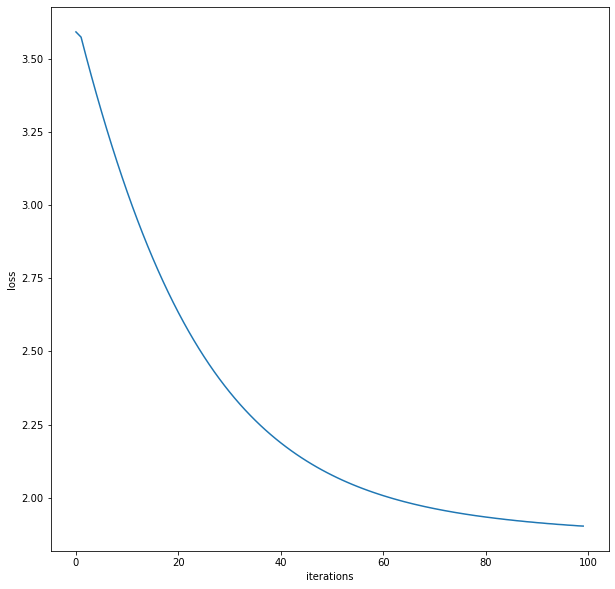

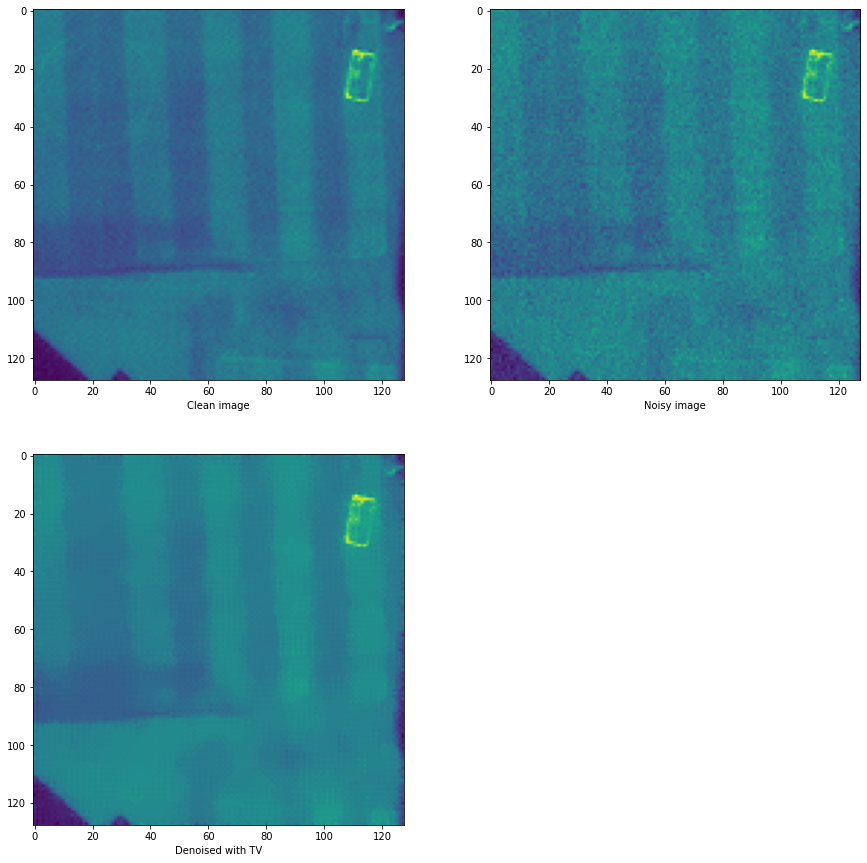

In [9]:
idx = 70

print(SNR[idx])

# test with fixed values for regul and step size

lambda_ = 0.01
rho = 0.01
maxiter_offline = 100

denoised_offline,loss= condat_vu_offline(y[idx,0,:,:][None,None,:,:].to(device), lambda_,rho, maxiter_offline)

plt.figure(figsize = (10,10))
plt.plot(loss.cpu())
plt.xlabel('iterations')
plt.ylabel('loss')


plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(x[idx,0,:,:].cpu())
plt.xlabel('Clean image')
plt.subplot(222)
plt.imshow(y[idx,0,:,:].cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(denoised_offline[0,0,:,:].detach().cpu())
plt.xlabel('Denoised with TV')


**Q: See the effects of tuning $\lambda$ and $\rho$ and look for more appropriate values**

# Optimizing wrt regularization parameter and step size with Pytorch


In [10]:
# Unrolled algorithm
    
n_iter = 15 # number of unrolled iterations

init = 0.01 # initial values for regul and step size

class Unrolled_proximal_algorithm(nn.Module):

        def __init__(self):
            super(Unrolled_proximal_algorithm, self).__init__()

            self.paramdict = nn.ParameterDict()
            self.tau = torch.nn.Parameter(init*torch.ones(train_lim).to(device).detach().requires_grad_(True))
            self.rho = torch.nn.Parameter(init*torch.ones(train_lim).to(device).detach().requires_grad_(True))
            
        def compute_spatial_gradient(self,x):

            h_grad = F.conv2d(x.float(), h_grad_kernel, padding = 1)
            v_grad = F.conv2d(x.float(), v_grad_kernel, padding = 1)

            return torch.cat((h_grad,v_grad),dim = 1)

        def compute_adjoint_spatial_gradient(self,q):

            q0 = q[:,0,:,:]
            q1 = q[:,1,:,:]

            h_grad = F.conv2d(q0[:,None,:,:].to(device).float(), h_grad_kernel, padding = 1)
            v_grad = F.conv2d(q1[:,None,:,:].to(device).float(), v_grad_kernel, padding = 1)

            return -(v_grad + h_grad)

        def proj_l2(self,x,tau):
            return x/torch.maximum(LA.norm(x, dim =1).unsqueeze(1).repeat(1, 2, 1, 1)/\
                                   tau,torch.tensor(1).to(device))

        def proj_unit_interval(self,x):
            return torch.maximum(torch.minimum(x,torch.tensor(1)),torch.tensor(0).to(device))

        def condat_vu(self,x):

            P = torch.clone(x).to(device)
            Q = torch.ones((x.size()[0],2,patch_size,patch_size)).to(device)

            gamma_max = (1/self.rho - 1/2)/opnorm
            gamma = torch.squeeze(gamma_max  - 0.1)

            for i in range(n_iter):
                grad = P-x
                P_old = torch.clone(P).double().to(device)
                P = self.proj_unit_interval(P-self.rho[:,None,None,None].to(device)*(grad + self.compute_adjoint_spatial_gradient(Q)))
                Q = self.proj_l2(Q+gamma[:,None,None,None]*self.compute_spatial_gradient(2*P-P_old),self.tau[:,None,None,None].to(device))
            return P, self.tau, self.rho

        def forward(self,x):
            P,tau,rho = self.condat_vu(x) # apply n_iter iterations of the optimization algorithm
            return P, tau,rho

        def outer_loss(self,y_hat,y):
            loss = torch.nn.MSELoss()(y_hat,y) # loss for the outer optimization (comparing to the ground truth)
#             loss = torch.nn.MSELoss()(y_hat,y) + torch.nn.MSELoss()\
#             (torch.sum(torch.log(1+self.compute_spatial_gradient(y_hat)**2),dim=1),\
#              torch.sum(torch.log(1+self.compute_spatial_gradient(y)**2),dim=1))
#             # we use a loss on both the images and their gradients to avoid oversmoothing
            return loss



**Q: Write the training loop in Pytorch to optimize over $\rho$ and $\tau$**

In [12]:
# Training loop        

outer_iterations = 200 # number of iterations for the inner optimization problem


def training_loop(x, model, optimizer, scheduler, n=outer_iterations):
        "Training loop for torch model."
        losses = []
        for i in range(n):
            optimizer.zero_grad()
            P,rho,tau = model.forward(y)
            loss = model.outer_loss(P, x)
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses.append(loss.detach().cpu()) 
            if i%5 == 0:
                print('iteration '+ str(i) + ', loss = '+ str(loss.detach().cpu()))
        return losses, P,rho,tau



In [13]:
# instantiate model

proximal_net= Unrolled_proximal_algorithm()
print(proximal_net)

# count the number of parameters (2 for each image)

params = list(proximal_net.parameters())
print(len(params))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(proximal_net)


Unrolled_proximal_algorithm(
  (paramdict): ParameterDict()
)
2


800

In [14]:
# Instantiate optimizer, and set a scheduler to decay the learning rate along iterations

opt = torch.optim.Adam(proximal_net.parameters(), lr=0.001)

sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

# train

losses, P, rho_out,tau_out = training_loop(x,proximal_net, opt, sch)
    

iteration 0, loss = tensor(0.0014, dtype=torch.float64)
iteration 5, loss = tensor(0.0013, dtype=torch.float64)
iteration 10, loss = tensor(0.0012, dtype=torch.float64)
iteration 15, loss = tensor(0.0011, dtype=torch.float64)
iteration 20, loss = tensor(0.0010, dtype=torch.float64)
iteration 25, loss = tensor(0.0009, dtype=torch.float64)
iteration 30, loss = tensor(0.0008, dtype=torch.float64)
iteration 35, loss = tensor(0.0007, dtype=torch.float64)
iteration 40, loss = tensor(0.0006, dtype=torch.float64)
iteration 45, loss = tensor(0.0006, dtype=torch.float64)
iteration 50, loss = tensor(0.0006, dtype=torch.float64)
iteration 55, loss = tensor(0.0005, dtype=torch.float64)
iteration 60, loss = tensor(0.0005, dtype=torch.float64)
iteration 65, loss = tensor(0.0005, dtype=torch.float64)
iteration 70, loss = tensor(0.0005, dtype=torch.float64)
iteration 75, loss = tensor(0.0004, dtype=torch.float64)
iteration 80, loss = tensor(0.0004, dtype=torch.float64)
iteration 85, loss = tensor(0.000

torch.Size([400])


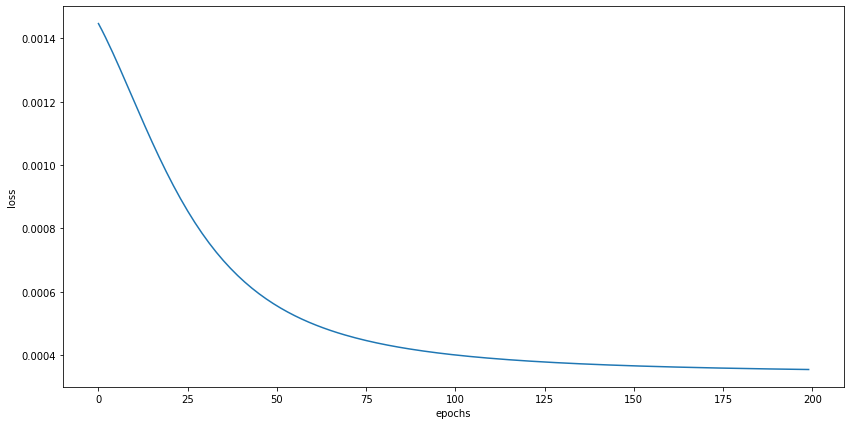

In [15]:
# check that the loss function is decreasing

plt.figure(figsize=(14, 7))
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')

# print(proximal_net.tau)    
# print(proximal_net.rho)

print(proximal_net.tau.size())

In [16]:
# compute all optimal parameters

proximal_net.eval()
# P_denoised,_,_ = proximal_net(y)


# Getting the optimal parameter values

params_values = torch.zeros(train_lim,2)
count = 0

for name, param in proximal_net.named_parameters():
    if param.requires_grad:
        params_values[:,count] = param.data
        count = count +1

tau_opt = params_values[:,0]
rho_opt = params_values[:,1]

# We remove the parameters from the previous computational graph

tau_opt.requires_grad = False 
rho_opt.requires_grad = False



tensor(4.4938)
Elapsed time:
0.01758861541748047


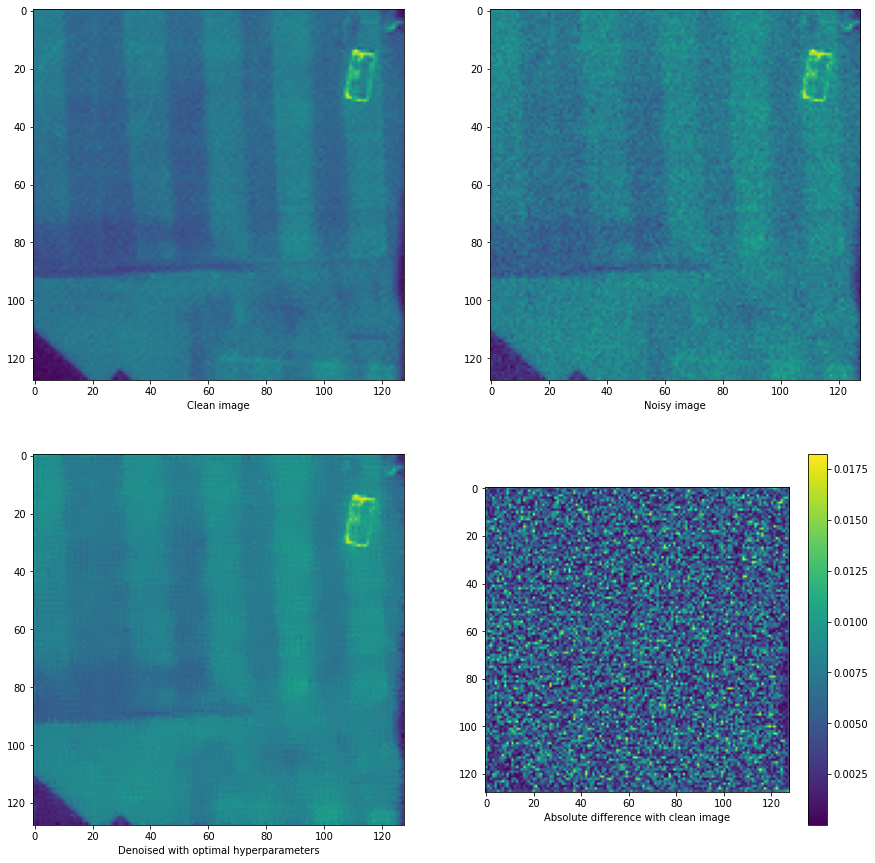

In [17]:
# Check results on the same image as before

import time

idx = 70

print(SNR[idx])

start = time.time()

denoised_img_opt,_ = condat_vu_offline(y[idx,0,:,:][None,None,:,:].to(device),\
                                       tau_opt[idx],rho_opt[idx], n_iter)
end = time.time()
print('Elapsed time:')
print(end - start)


plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(x[idx,0,:,:].cpu())
plt.xlabel('Clean image')
plt.subplot(222)
plt.imshow(y[idx,0,:,:].cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(denoised_img_opt[0,0,:,:].detach().cpu())
plt.xlabel('Denoised with optimal hyperparameters')
plt.subplot(224)
plt.imshow(torch.abs(denoised_img_opt[0,0,:,:].detach().cpu()-y[idx,0,:,:].cpu()))
plt.xlabel('Absolute difference with clean image')
plt.colorbar()


tensor(4.4938)
Elapsed time:
0.10630106925964355
distance between optimal image and GT: tensor(0.6151, dtype=torch.float64)
distance between TV image and GT: tensor(0.6094, dtype=torch.float64)


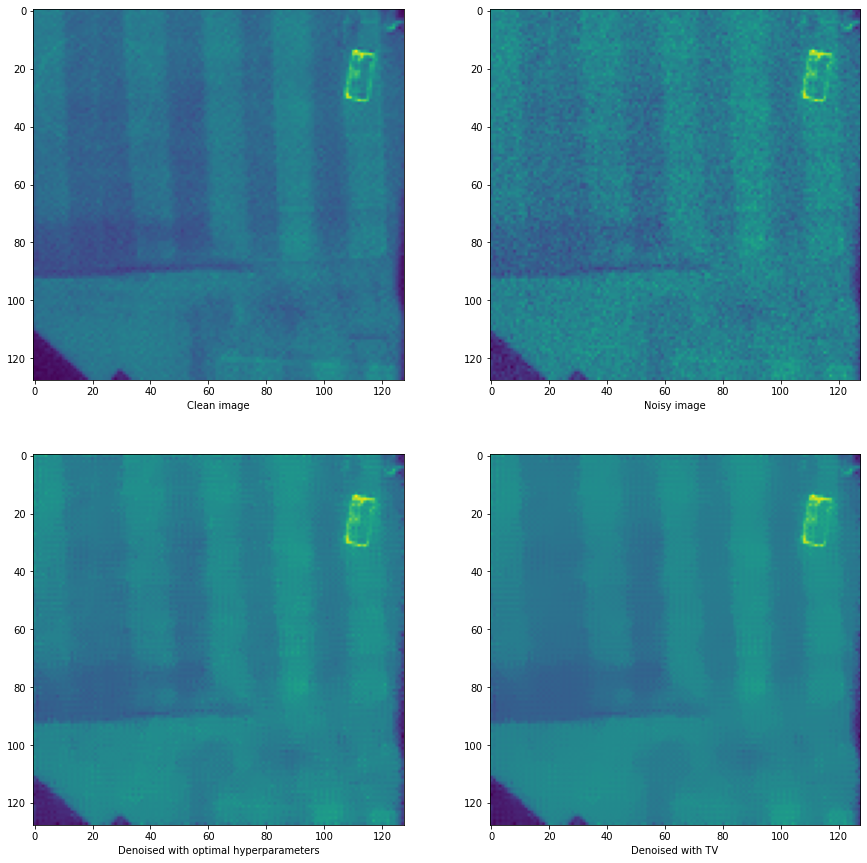

In [18]:
# Compare with TV and fixed hyperparameters

print(SNR[idx])

maxiter_offline = 100

start = time.time()

denoised_offline,_ = condat_vu_offline(y[idx,0,:,:][None,None,:,:].to(device), 0.01,0.01, maxiter_offline)

end = time.time()
print('Elapsed time:')
print(end - start)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(x[idx,0,:,:].cpu())
plt.xlabel('Clean image')
plt.subplot(222)
plt.imshow(y[idx,0,:,:].cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(denoised_img_opt[0,0,:,:].detach().cpu())
plt.xlabel('Denoised with optimal hyperparameters')
plt.subplot(224)
plt.imshow(denoised_offline[0,0,:,:].cpu())
plt.xlabel('Denoised with TV')


# show distances to GT

print('distance between optimal image and GT: ' + str(LA.norm(x[idx,0,:,:]-denoised_img_opt[0,0,:,:]).detach().cpu()))
print('distance between TV image and GT: ' + str(LA.norm(x[idx,0,:,:]-denoised_offline[0,0,:,:]).detach().cpu()))

Text(0.5, 0, 'Denoised with TV')

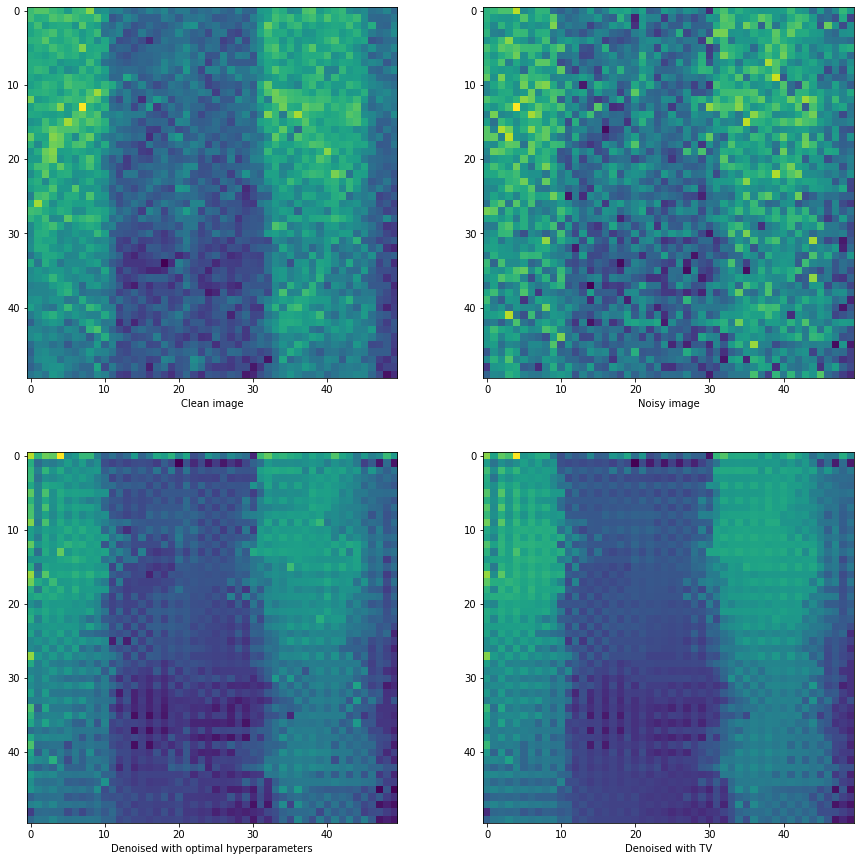

In [19]:
# Same with a zoom in

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(x[idx,0,:50,:50].cpu())
plt.xlabel('Clean image')
plt.subplot(222)
plt.imshow(y[idx,0,:50,:50].cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(denoised_img_opt[0,0,:50,:50].detach().cpu())
plt.xlabel('Denoised with optimal hyperparameters')
plt.subplot(224)
plt.imshow(denoised_offline[0,0,:50,:50].cpu())
plt.xlabel('Denoised with TV')

# Learning a function between images and optimal regularization parameters

Now we want to go further: learn a relationship between an input noisy image and the optimal hyperparameters we found in the previous section. To do that we use a CNN. We could have done both operations at the same time, but this leads to a complex and memory intensive model that is hard to parameterize and train. So we resort to this two step procedure.

We use Pytorch Lightning for quick prototyping and training of the network.

In [20]:
#automatic tuning

# We define a Dataset Class

class PAN_image_patches(Dataset):
    def __init__(self, noisy ,tau,rho, **kwargs):
        
        self.noisy = noisy.float()
        self.regul = torch.stack((tau,rho))
        
    def __len__(self):
        return len(self.noisy)
        
    def __getitem__(self, index):
        noisy = self.noisy[index]
        regul = self.regul[:,index]

        return noisy, regul

# We keep 100 images for testing
    
train_lim_regression = train_lim - 100


# Creating training and testing datasets

train = PAN_image_patches(noisy_imgs[0:train_lim_regression,:,:,:], \
                          tau_opt[0:train_lim_regression],rho_opt[0:train_lim_regression])
test = PAN_image_patches(noisy_imgs[train_lim_regression+1:train_lim,:,:,:],\
                         tau_opt[train_lim_regression+1:train_lim],rho_opt[train_lim_regression+1:train_lim])

# Creating Dataloaders

batch_size = 32

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=False, num_workers=0)


**Q: Set up a simple CNN architecture to get the parameters as a function of the input image**

In [22]:
# Regression CNN architecture

class regressor_regul(pl.LightningModule):

    def __init__(self):
        super(regressor_regul, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, stride = 1, kernel_size = 3, padding = 1) # padding to preserve dims
        self.conv2 = nn.Conv2d(32,64 , stride = 1, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64,32 , stride = 1, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(32,16 , stride = 1, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8*8*16,50) # at this step we have 8*8 patches for each filter
        self.fc2 = nn.Linear(50,2) # 2 parameters to obtain
        
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  # at this step we have 8*8 patches for each filter
        x = F.relu(self.fc1(x.view(-1,8*8*16))) 
        x = self.fc2(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def loss(self,x,y):
        loss = torch.nn.MSELoss()(x,y) # regular MSE loss, but can be adapted depending on the needs
        return loss

    def training_step(self, batch, batch_idx):
        (x,y) = batch
        y_hat = self.forward(x.double())
        loss = self.loss(y.double(),y_hat)
        self.log('training_loss', loss) # logging to tensorboard 
        return loss
    
    def validation_step(self, batch, batch_idx):
        (x,y) = batch
        y_hat= self.forward(x.double())
        loss = self.loss(y.double(),y_hat)
        self.log('test_loss', loss) # logging to tensorboard 
        return loss



In [23]:
# instantiate model

CNN_regressor = regressor_regul().to(device).double()
print(CNN_regressor)

# count parameters

params = list(proximal_net.parameters())
print(len(params))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(CNN_regressor)

regressor_regul(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
2


93256

In [24]:
# train 

epochs = 30

tb_logger = pl_loggers.TensorBoardLogger('logs_regression/') # store logs in this file

k = 5 # log every 5 steps

trainer = pl.Trainer(max_epochs = epochs, logger = tb_logger,gpus= 1,log_every_n_steps=k)
trainer.fit(CNN_regressor,trainloader, testloader)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 320   
1 | conv2 | Conv2d    | 18.5 K
2 | conv3 | Conv2d    | 18.5 K
3 | conv4 | Conv2d    | 4.6 K 
4

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


We now test the quality of our regression CNN on a test image (for which we have computed the optimal parameters in the first part, but that has not been shown to the CNN):

tensor(8.9823)
tensor(0.0379)
tensor(0.0344)
tensor(0.0536, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(0.0469, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(2.4975, device='cuda:0', dtype=torch.float64)
tensor(2.8924, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
tensor(2.8545, device='cuda:0', dtype=torch.float64)


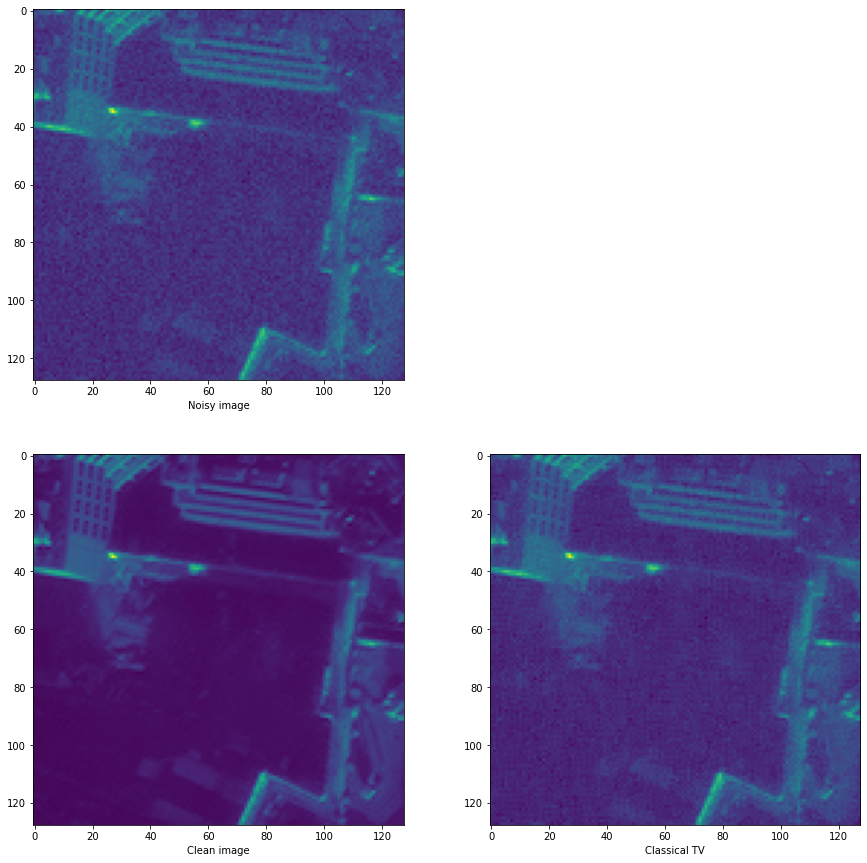

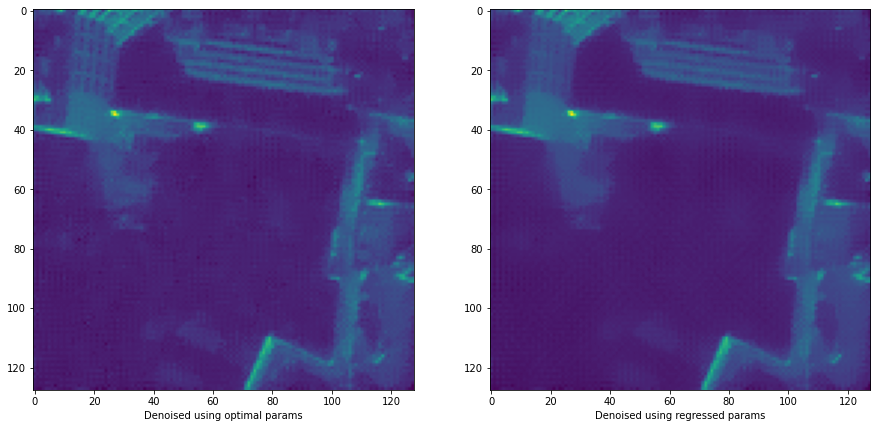

In [25]:
# Check results on a test image (idx>700)

idx = 350
print(SNR[idx])

# recover the corresponding optimal parameters

print(tau_opt[idx])
print(rho_opt[idx])

# recover the estimates from the CNN

CNN_regressor.to(device).eval()

test_img_clean = x[idx,:,:,:][None,:,:,:].to(device).double()
test_img_noisy = y[idx,:,:,:][None,:,:,:].to(device).double()

params_idx = CNN_regressor(test_img_noisy)

tau_idx = params_idx[0][0]
rho_idx = params_idx[0][1]

print(tau_idx)
print(rho_idx)

# Get denoised image with fixed hyperparameters

maxiter_offline = 100
denoised_offline,_ = condat_vu_offline(test_img_noisy.to(device), 0.01,0.01, maxiter_offline)

# using optimized (not regressed) parameters to denoise and the offline algorithm (should give the same output)

denoised_learned_opt,_ = condat_vu_offline(test_img_noisy, tau_opt[idx],rho_opt[idx], n_iter)

# using regressed parameters to optimize

denoised_learned_reg,_ = condat_vu_offline(test_img_noisy, tau_idx,rho_idx, n_iter)


# show results

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(y[idx,0,:,:].cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(x[idx,0,:,:].cpu())
plt.xlabel('Clean image')
plt.subplot(224)
plt.imshow(denoised_offline[0,0,:,:].cpu())
plt.xlabel('Classical TV')

plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(denoised_learned_opt[0,0,:,:].cpu())
plt.xlabel('Denoised using optimal params')
plt.subplot(122)
plt.imshow(denoised_learned_reg[0,0,:,:].detach().cpu())
plt.xlabel('Denoised using regressed params')

# show distances to GT

print(LA.norm(x[idx,0,:,:]-denoised_learned_opt[0,0,:,:]))
print(LA.norm(x[idx,0,:,:]-denoised_learned_reg[0,0,:,:]))
print(LA.norm(x[idx,0,:,:]-denoised_offline[0,0,:,:]))

Finally, we test on a patch coming from an image acquired over Trenton, NJ, USA to see if our strategy allows to generalize to different types of images

In [26]:
# load image

I_final = torch.tensor(np.array(imageio.imread(folder_name +'PAN_tren.tif')[:,:],dtype=float))[None,None,:,:]

# rescale it between 0 and 1

mini = torch.min(I_final.flatten())
maxi = torch.max(I_final.flatten())

I_final = (I_final-mini)/(maxi-mini)

# select a small patch of same size as before

img_final_test = I_final[0,0,1250:1250+patch_size,1000:1000+patch_size]

# display full image

plt.figure(figsize = (30,30))
plt.imshow(I_final[0,0,:,:],cmap = 'gray')


# fix SNR and noise variance

SNR_new = 5

var_noise = torch.var(img_final_test.flatten())/(10**(SNR_new/10))

# generate noisy image

img_final_test_noisy = img_final_test + torch.sqrt(var_noise)*torch.randn((patch_size,patch_size))

# display 

plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(img_final_test)
plt.xlabel('Clean image')
plt.subplot(122)
plt.imshow(img_final_test_noisy)
plt.xlabel('Noisy image')

Output hidden; open in https://colab.research.google.com to view.

tensor(0.0661, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(0.0594, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(19.0549, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
tensor(20.5579, device='cuda:0', dtype=torch.float64)


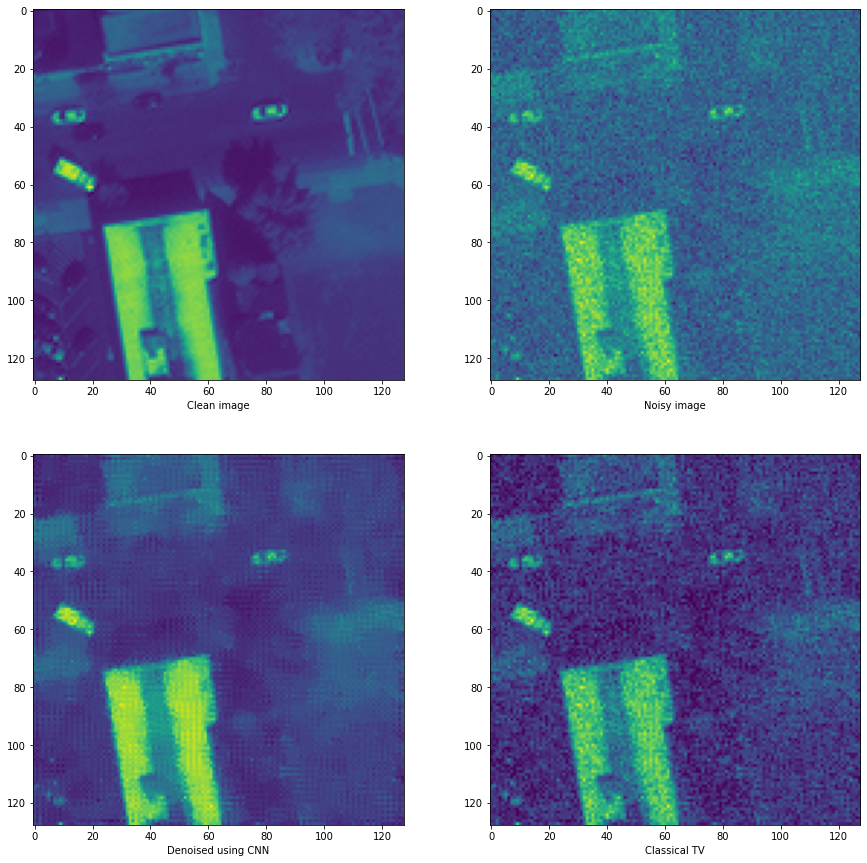

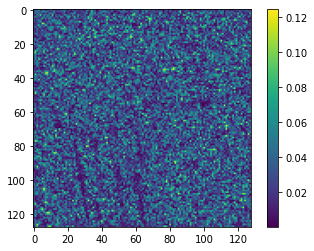

In [27]:
# get estimated hyperparameters

params_idx = CNN_regressor(img_final_test_noisy[None,None,:,:].to(device))

tau_idx = params_idx[0][0]
rho_idx = params_idx[0][1]

print(tau_idx)
print(rho_idx)

# denoise using fixed parameters and regressed ones L1 ball of radius τ

maxiter_offline = 100
denoised_offline,_ = condat_vu_offline(img_final_test_noisy[None,None,:,:].to(device), 0.01,0.01, maxiter_offline)
denoised_learned,_ = condat_vu_offline(img_final_test_noisy[None,None,:,:].to(device), tau_idx,rho_idx, n_iter)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(img_final_test.cpu())
plt.xlabel('Clean image')
plt.subplot(222)
plt.imshow(img_final_test_noisy.cpu())
plt.xlabel('Noisy image')
plt.subplot(223)
plt.imshow(denoised_learned[0,0,:,:].detach().cpu())
plt.xlabel('Denoised using CNN')
plt.subplot(224)
plt.imshow(denoised_offline[0,0,:,:].cpu())
plt.xlabel('Classical TV')

# display absolute differences between both estimates

plt.figure()
plt.imshow(torch.abs(denoised_offline[0,0,:,:].cpu()-denoised_learned[0,0,:,:].detach().cpu()))
plt.colorbar()

# show distances to GT

print(LA.norm(x[idx,0,:,:]-denoised_learned[0,0,:,:]))
print(LA.norm(x[idx,0,:,:]-denoised_offline[0,0,:,:]))

**Q: Extend the experiment to values of the regularization and/or the step sizes that vary with the iteration number**